# DMQC Report: WMO 4902410

## Current status and metadata: 

- MetOcean NOVA float deployed in the Lab Sea
- Deployed in April 2017, inactive as of 2021
- Completed 126 cycles, though float reports 257 cycles (?)
- No in-air data
- Core files in D mode, B files in R mode

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from netCDF4 import Dataset

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4902410 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

# check what/if anything is done already
nc = Dataset(flt.__Sprof__)
print(bgc.io.read_ncstr(nc['SCIENTIFIC_CALIB_COMMENT'][:][50,-1,3,:]))
print(nc['DOXY_ADJUSTED'][:][-1,:]/nc['DOXY'][:][-1,:])
nc.close()

\Users\GordonC\Documents\data\Argo\dac\meds\4902410\4902410_BRtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902410\4902410_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902410\4902410_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902410\4902410_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902410\4902410_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4902410\4902410_tech.nc
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec
Bounding climatological profile(s) missing data - taking simple average

## DOXY Audit Status

- If the float has any profiles present in the DOXY audit, which are they are why?
- Likely will usually be left empty/deleted

In [2]:
audit_file = list(Path('../../../audit/').glob('DOXY_WOA*'))[-1]
df = pd.read_csv(audit_file, sep='\t', header=25)
df = df.loc[df.WMO == wmo]
df['date'] = [datestr2num(t) for t in df['profile date']]
print(df['WOA G_raw'].mean())

nan


## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

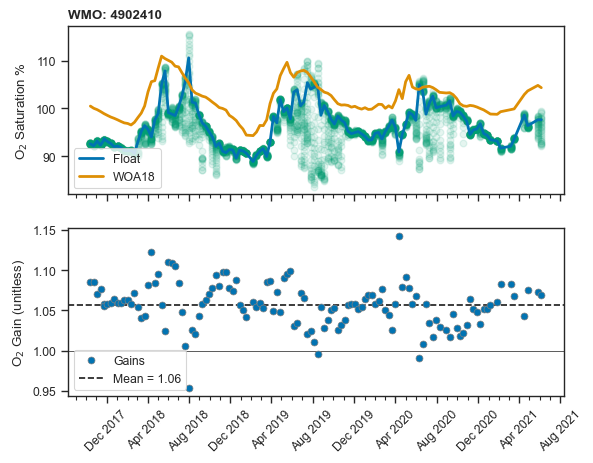

In [3]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: [notes on what this figure tells you here] 

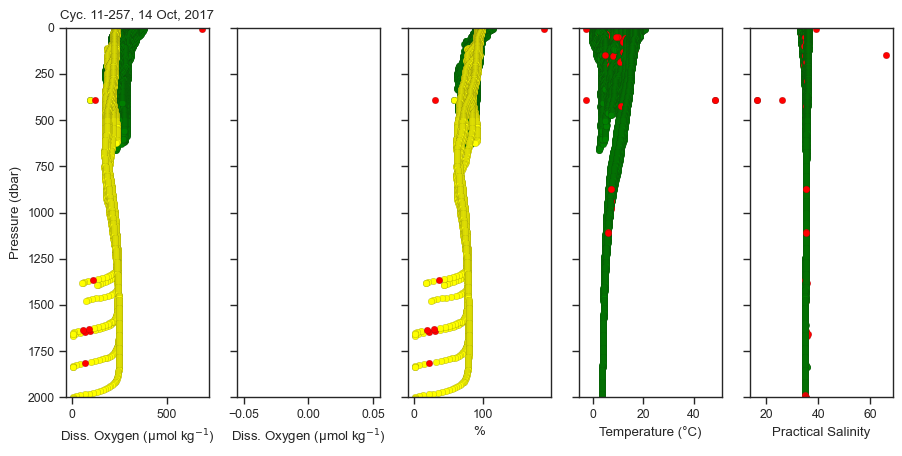

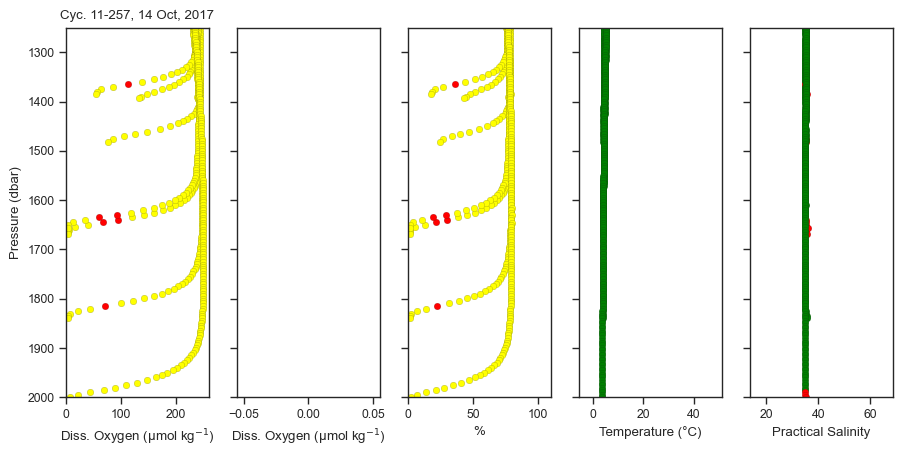

In [4]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((2000, 1250))
g.axes[0].set_xlim((0, 260))
g.axes[2].set_xlim((0, 110))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)

In [5]:
bad_cycles = flt.df.loc[flt.df.DOXY < 150].CYCLE.unique()
bad_cycles

array([129., 139., 143., 148., 152., 225., 229., 256., 257.])

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: [notes on what this figure tells you here] 

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.

In [6]:
flt.reset()
bad_oxygen = (flt.df.CYCLE == 148) & (flt.df.PRES > 1415) # index defining where the oxygen should be flagged as bad
bad_oxygen = (bad_oxygen) | ((flt.df.CYCLE == 143) & (flt.df.PRES > 1330))
bad_oxygen = (bad_oxygen) | ((flt.df.CYCLE == 152) & (flt.df.PRES > 1310))
bad_oxygen = (bad_oxygen) | ((flt.df.CYCLE == 225) & (flt.df.PRES > 1560))
bad_oxygen = (bad_oxygen) | ((flt.df.CYCLE == 229) & (flt.df.PRES > 1550))
bad_oxygen = (bad_oxygen) | ((flt.df.CYCLE == 256) & (flt.df.PRES > 1880))
bad_oxygen = (bad_oxygen) | ((flt.df.CYCLE == 257) & (flt.df.PRES > 1730))
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
G = np.nanmean(new_gains)
print(G)

flt.update_field('DOXY_ADJUSTED', G*flt.DOXY)
flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_QC == 3)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))


Updating DOXY_QC on 679 levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC

Calculating gains using WOA surface data and float O2 percent saturation...
1.0570341878765077
Updating DOXY_ADJUSTED on all levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Updating DOXY_ADJUSTED_QC on all levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Updating DOXY_ADJUSTED_QC on 4065 levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Updating DOXY_ADJUSTED_QC on 67

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

Updating DOXY_QC on 21453 levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Updating DOXY_ADJUSTED_QC on 139 levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Updating DOXY_ADJUSTED_QC on 205 levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Updating DOXY_ADJUSTED_QC on 40254 levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_ADJUSTED_QC
hello PSAL_QC
hello PSAL_ADJUSTED_QC
hello DOXY_QC
hello DOXY_ADJUSTED_QC
hello O2Sat_QC
Updating DOXY_ADJUSTED on 40254 levels
hello POSITION_QC
hello PRES_QC
hello PRES_ADJUSTED_QC
hello TEMP_QC
hello TEMP_AD

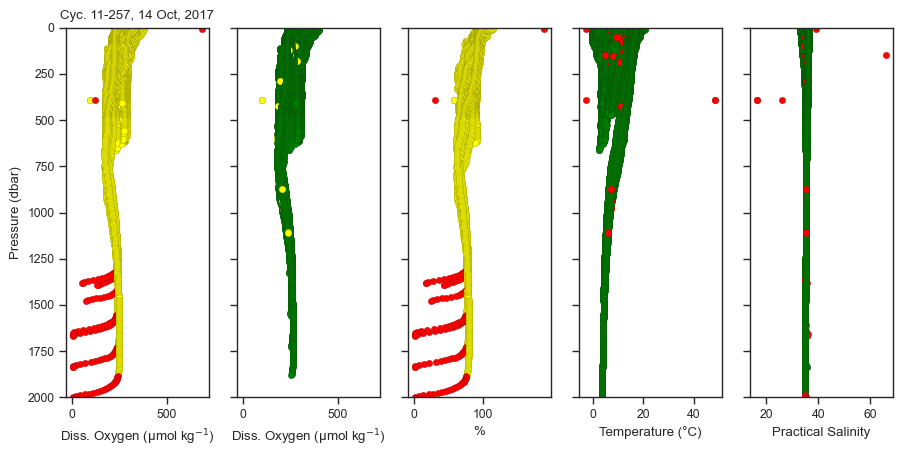

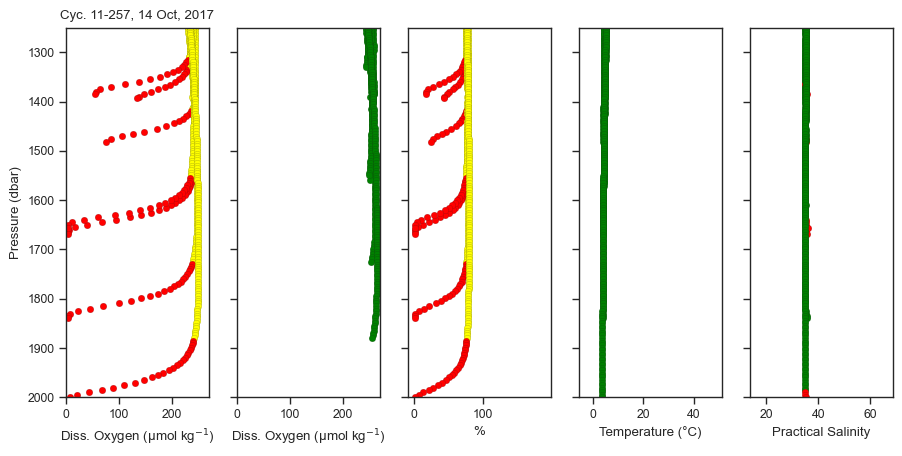

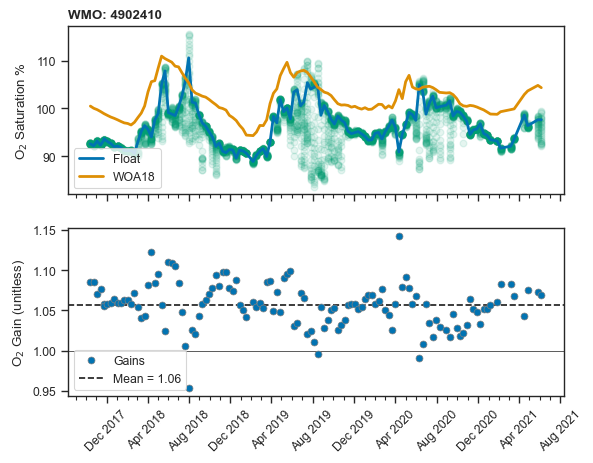

In [7]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# fill in DOXY_ADJUSTED_QC appropriately
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.DOXY_ADJUSTED.isna())
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[1].set_xlim(g.axes[0].get_xlim())
g.fig.savefig(fig_path / 'qcprofiles_postqc.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((2000, 1250))
g.axes[0].set_xlim((0, 270))
g.axes[1].set_xlim((0, 270))
g.fig.savefig(fig_path / 'qcprofiles_deep_postqc.png', bbox_inches='tight', dpi=250)

flt.clean()
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

In [8]:
# export the files - for R to D mode
flt.export_files(data_mode='D')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902410/profiles/BD4902410_011.nc...('N_PROF', 'N_CALIB', 'N_PARAM', 'STRING256') 0 0 2
done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902410/profiles/BD4902410_014.nc...('N_PROF', 'N_CALIB', 'N_PARAM', 'STRING256') 0 0 2
done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902410/profiles/BD4902410_019.nc...('N_PROF', 'N_CALIB', 'N_PARAM', 'STRING256') 0 0 2
done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902410/profiles/BD4902410_020.nc...('N_PROF', 'N_CALIB', 'N_PARAM', 'STRING256') 0 0 2
done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902410/profiles/BD4902410_021.nc...('N_PROF', 'N_CALIB', 'N_PARAM', 'STRING256') 0 0 2
done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4902410/profiles/BD4902410_022.nc...('N_PROF', 'N_CALIB', 'N_PARAM', 'STRING256') 0 0 2
done
Working on D-mode file /User

In [9]:
# from pathlib import Path
# import pandas as pd
# from netCDF4 import Dataset
# import copy

# wmo = 4900874
# loc = Path(f'/Users/GordonC/Documents/data/Argo/dac/meds/D/{wmo}/profiles/')
# files = pd.read_csv(Path(f'../../../checker/summary/{wmo}/files.txt'))
# varname = 'DOXY'
# for fn in files.files:
#     print(fn)
#     nc = Dataset(loc / fn, 'r+')
#     print(nc['DOXY'][:])
#     flags = copy.deepcopy(nc[varname+'_QC'][:])
#     flags[nc[varname][:].mask] = b'9'
#     nc[varname+'_QC'][:] = flags
#     if varname == 'DOXY':
#         flags = copy.deepcopy(nc[varname+'_ADJUSTED_QC'][:])
#         flags[nc[varname][:].mask] = b'9'
#         nc[varname+'_ADJUSTED_QC'][:] = flags
#     profile = copy.deepcopy(nc['PROFILE_DOXY_QC'][:])
#     profile[0] = b'A'
#     nc['PROFILE_DOXY_QC'][:] = profile
#     nc.close()